In [11]:
import pandas as pd # For dataframes (tables)
import numpy as np # For arange
import matplotlib.pyplot as plt # For plots
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math # for sqrt
from sklearn.model_selection import cross_val_score, KFold
import pickle # to serialize/deserialize objects
import sys
sys.path.append("..")
from statistics import mean

from andrea_models import AndreaLinearRegression # In the course library
import feature_engineering # From the course library

# Load the CSV file
csv_file = "../Data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
data = pd.read_csv(csv_file, sep=',')

print(data.head())

   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0  26.0     0.0     0.0   
1              0.0     1.0       1.0        1.0  26.0     1.0     1.0   
2              0.0     0.0       0.0        1.0  26.0     0.0     0.0   
3              0.0     1.0       1.0        1.0  28.0     1.0     0.0   
4              0.0     0.0       0.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           1.0     0.0  ...            1.0   
1                   0.0           0.0     1.0  ...            1.0   
2                   0.0           1.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      3.0       5.0      30.0       0.0  1.0   4.0   

In [12]:
for col in ['BMI', 'PhysHlth', 'MentHlth']:
    data[f'log_{col}'] = np.log1p(data[col])

In [13]:
data_train, data_test = train_test_split(data, test_size=0.3)


# Scikit learn models expect matrices. We first transform
# the dataframe into an array
X_train = data_train[['GenHlth'] ].values

# Scikit learn models expect matrices with multiple
# rows and columns as X. X_train has instead just one column
# ==> The following code is necessary
X_train = X_train.reshape(-1,1)

y_train = data_train['Diabetes_binary'].values


# Do the same for the test dataset
X_test = data_test[[ 'GenHlth'] ].values.reshape(-1,1)
y_test = data_test['Diabetes_binary'].values



In [14]:
model = AndreaLinearRegression()
model.fit(X_train, y_train, column_names=['GenHlth'])
model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     9863.
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        15:43:45   Log-Likelihood:                -31418.
No. Observations:               49484   AIC:                         6.284e+04
Df Residuals:                   49482   BIC:                         6.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0204      0.006     -3.631      0.0

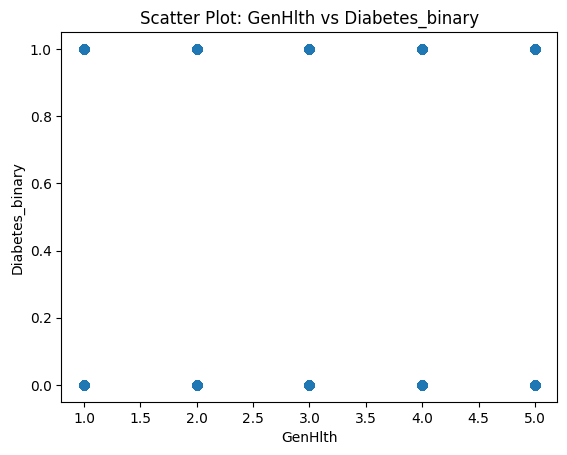

In [15]:
plt.scatter(data['GenHlth'], data['Diabetes_binary'], alpha=0.5)
plt.xlabel('GenHlth')
plt.ylabel('Diabetes_binary')
plt.title('Scatter Plot: GenHlth vs Diabetes_binary')
plt.show()

In [16]:
# Générer des exemples de valeurs pour "GenHlth"
newGenHlthSamples = data_train['GenHlth'].sample(4).values.reshape(-1, 1)

# Prédire les étiquettes avec le modèle
predicted_values = model.predict(newGenHlthSamples)
print(predicted_values)

[0.34623939 0.52958131 0.16289748 0.34623939]


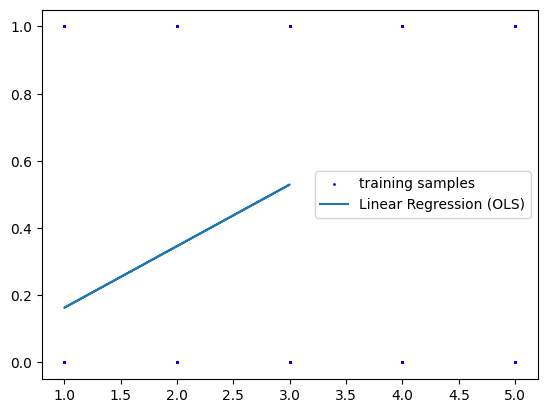

In [17]:
fig, ax = plt.subplots() # This creates just a canvas

ax.scatter(X_train,y_train,color='blue',s=1,
           label="training samples")

ax.plot(newGenHlthSamples,predicted_values, label="Linear Regression (OLS)")
ax.legend()


In [18]:
y_pred = model.predict(X_test)
pd.DataFrame({'true':y_test,'pred':y_pred})

,true,pred
0,0.0,0.346239
1,0.0,0.529581
2,0.0,0.712923
3,0.0,0.346239
4,1.0,0.529581
...,...,...
21203,0.0,0.529581
21204,1.0,0.712923
21205,1.0,0.529581
21206,0.0,0.162897


In [19]:
MSE = mean_squared_error(y_test, y_pred)
RMSE_one_feature = math.sqrt(MSE)
RMSE_one_feature
model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     9863.
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        15:43:46   Log-Likelihood:                -31418.
No. Observations:               49484   AIC:                         6.284e+04
Df Residuals:                   49482   BIC:                         6.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0204      0.006     -3.631      0.0

In [20]:

k_fold = KFold(n_splits=5, shuffle=True, random_state=3)

scores = cross_val_score(AndreaLinearRegression(),
                         X_train, y_train, cv=k_fold,
                         scoring='neg_mean_squared_error')

rmse = math.sqrt(mean(-scores))
rmse

0.456604352853337

In [21]:
data = data.drop(columns=['BMI', 'PhysHlth', 'MentHlth'])
data_train, data_test = train_test_split(data, test_size=0.3)

# Prepare the training data for all features
X_train_full = data_train.drop(columns=['Diabetes_binary']).values
y_train_full = data_train['Diabetes_binary'].values
column_names = data_train.drop(columns=['Diabetes_binary']).columns.tolist()

# Train the model with all features
model_full = AndreaLinearRegression()
model_full.fit(X_train_full, y_train_full, column_names=column_names)

# Model summary
model_full.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     1065.
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        15:43:46   Log-Likelihood:                -26683.
No. Observations:               49484   AIC:                         5.341e+04
Df Residuals:                   49462   BIC:                         5.360e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -1.6840 

In [22]:
# Refaire la validation croisée
new_scores = cross_val_score(AndreaLinearRegression(),
                             X_train_full, y_train_full, cv=k_fold,
                             scoring='neg_mean_squared_error')

new_rmse = math.sqrt(mean(-new_scores))
new_rmse

0.4151142504616198